In [14]:
import importlib
importlib.reload(cluster_util)
import cluster_util

# Notebook error analysis 

## Refining error types - Vectorization and clustering method selection


use a subset of the dedupped GitHub error dataset with ename == valueerror

### Clustering value errors

load tokenized error dataset, evalue_tokenized

In [1]:
import pandas as pd 
import cluster_util, config

df_mlerr_g_mlbugs_unique = pd.read_excel(config.path_github_error_analysis.joinpath("df_mlerr_g_mlbugs_filtered_dedup.xlsx"))
# df_mlerr_k_mlbugs_unique = pd.read_excel(config.path_kaggle_error_analysis.joinpath("df_mlerr_k_mlbugs_filtered_dedup.xlsx"))

err_descs = df_mlerr_g_mlbugs_unique['evalue_tokenized'].values.astype('U')

C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


path_default=WindowsPath('C:/Users/yirwa29/Downloads/Dataset-Nb')


### 1 Vectorization
##### 1. tfidf
too high dimension

In [3]:
X_tfidf = cluster_util.vectorizer_tfidf(err_descs)
X_tfidf.shape

(1808, 3047)

##### 2. sentence transformers

https://github.com/UKPLab/sentence-transformers

https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2

sentence to vector, dimension -384

2 embeddings with different preprocessing

In [4]:
X_transformers = cluster_util.vectorizer_sentence2vec(err_descs)
X_transformers.shape

(1808, 384)

In [6]:
df_mlerr_g_mlbugs_valueerr_unique['evalue_tokenized_transformer'] = df_mlerr_g_mlbugs_valueerr_unique['evalue'].apply(cluster_util.preprocess_text_transformer)
err_descs1 = df_mlerr_g_mlbugs_valueerr_unique['evalue_tokenized_transformer'].values.astype('U')

X_transformers1 = cluster_util.vectorizer_sentence2vec(err_descs1)

##### 3. word embeddings - GloVe

Turn sentences to vectors via word embeddings by taking the mean/sum of all word embeddings of the sentence

using GloVe with dimension 200

In [2]:
import numpy as np

glove_vectors = cluster_util.load_glove("C:/Users/yirwa29/Downloads/Dataset-Nb/glove.6B/glove.6B.200d.txt")
X_glove = np.array([cluster_util.vectorizer_word2vec(xi, glove_vectors, 200) for xi in err_descs])
X_glove.shape

Loaded 400000 word vectors from GloVe.


(13153, 200)

### 2. Clustering with vectorized error values


##### 1. tfidf

In [19]:
##PCA
n_components = cluster_util.select_pca_n_basedon_variance(X_tfidf)
X_tfidf_pca = cluster_util.pca(X_tfidf, n_components=n_components)

pca: 433 components can explain 80.04% variance of the data


In [45]:
## kmeans
K_range = range(2,100)
inertias = cluster_util.elbow_for_kmean(X_tfidf_pca, K_range = K_range)

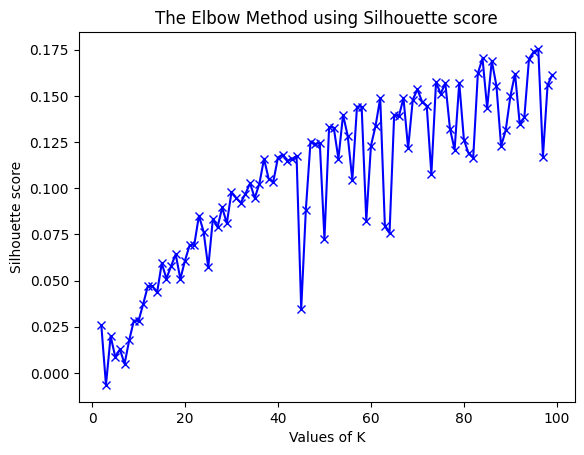

In [46]:
import matplotlib.pyplot as plt 

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method using Silhouette score')
plt.show()

In [22]:
num_clusters = 80
res = cluster_util.cluster_kmeans(X_tfidf_pca, n_clusters=num_clusters)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_km_tfidf"] = res

In [18]:
## dbscan

In [23]:
eps_tfidf = cluster_util.epsilon_search_dbscan(X_tfidf_pca)
print(eps_tfidf)
res = cluster_util.cluster_dbscan(X_tfidf_pca, eps=eps_tfidf, min_samples=2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_dbscan_tfidf"] = res

0.7069184405392713
Estimated no. of clusters: 197
Estimated no. of noise points: 760


In [22]:
## OPTICS

In [25]:
res = cluster_util.cluster_optics(X_tfidf_pca, min_samples = 2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_optics_tfidf"] = res

Estimated no. of clusters: 330
Estimated no. of noise points: 899


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [ ]:
# hierarchical - AgglomerativeClustering

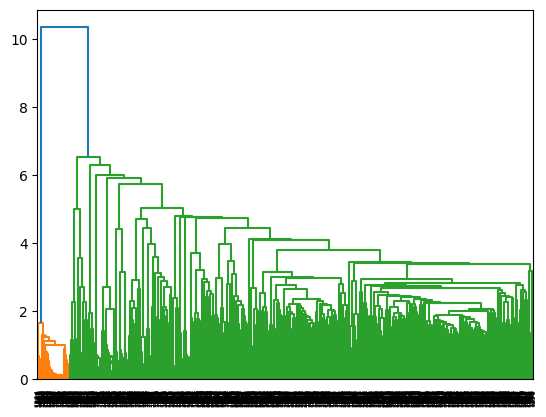

In [50]:
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

Dendrogram = shc.dendrogram((shc.linkage(X_tfidf_pca, method ='ward')))

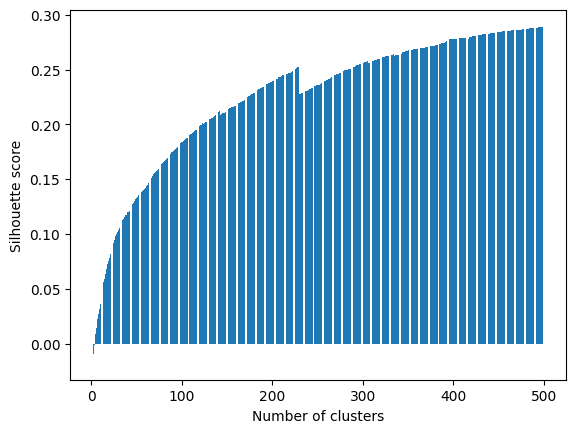

In [87]:
import matplotlib.pyplot as plt

ks = range(2,500)
silhouette_scores_tfidf = []
for k in ks:
    model = AgglomerativeClustering(n_clusters = k, linkage="ward")
    model.fit(X_tfidf_pca) # model.fit_predict(X_tfidf_pca)
    silhouette_scores_tfidf.append(cluster_util.eval_cluster_silhouette(X_tfidf_pca, model.labels_))

# plot
plt.bar(ks, silhouette_scores_tfidf)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

##### 2. sentence transformers

In [26]:
##PCA
n_components = cluster_util.select_pca_n_basedon_variance(X_transformers)
X_transformers_pca = cluster_util.pca(X_transformers, n_components=n_components)

pca: 96 components can explain 80.16% variance of the data


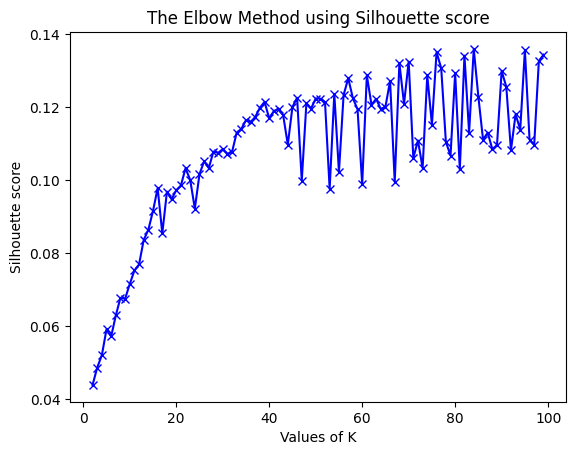

In [47]:
## kmeans
K_range = range(2,100)
inertias = cluster_util.elbow_for_kmean(X_transformers_pca, K_range = K_range) # X_transformers1

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method using Silhouette score')
plt.show()

In [29]:
num_clusters = 40
res = cluster_util.cluster_kmeans(X_transformers_pca, n_clusters=num_clusters)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_km_transformers"] = res

In [32]:
## dbscan

In [30]:
eps_transformers = cluster_util.epsilon_search_dbscan(X_transformers_pca)
print(eps_transformers)
res = cluster_util.cluster_dbscan(X_transformers_pca, eps=eps_transformers, min_samples=2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_dbscan_transformers"] = res

0.7433380154692085
Estimated no. of clusters: 123
Estimated no. of noise points: 404


In [39]:
## OPTICS

In [31]:
res = cluster_util.cluster_optics(X_transformers_pca, min_samples = 2)
df_mlerr_g_mlbugs_valueerr_unique.loc[:,"cluster_optics_transformers"] = res

Estimated no. of clusters: 326
Estimated no. of noise points: 883


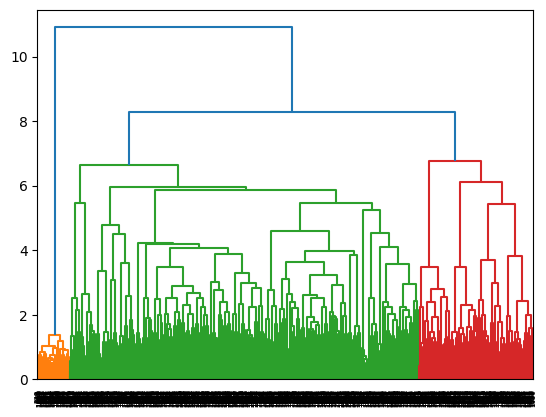

In [53]:
# hierarchical - AgglomerativeClustering
Dendrogram = shc.dendrogram((shc.linkage(X_transformers_pca, method ='ward')))

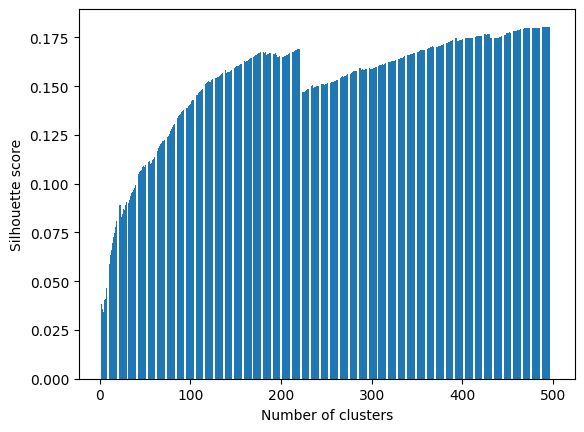

In [88]:
import matplotlib.pyplot as plt

ks = range(2,500)
silhouette_scores_transformers = []
for k in ks:
    model = AgglomerativeClustering(n_clusters = k, linkage="ward")
    model.fit(X_transformers_pca) # model.fit_predict(X_transformers_pca)
    silhouette_scores_transformers.append(cluster_util.eval_cluster_silhouette(X_transformers_pca, model.labels_))

# plot
plt.bar(ks, silhouette_scores_transformers)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

##### 3. word embeddings - GloVe

In [3]:
##PCA
n_components = cluster_util.select_pca_n_basedon_variance(X_glove)
X_glove_pca = cluster_util.pca(X_glove, n_components=n_components)

pca: 46 components can explain 80.16% variance of the data


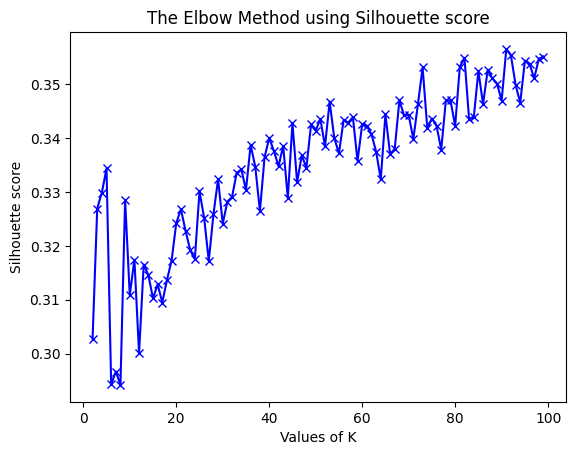

In [4]:
## kmeans
K_range = range(2,100)
inertias = cluster_util.elbow_for_kmean(X_glove_pca, K_range = K_range)

import matplotlib.pyplot as plt

plt.plot(K_range, inertias, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('The Elbow Method using Silhouette score')
plt.show()

In [18]:
num_clusters = 60
res = cluster_util.cluster_kmeans(X_glove_pca, n_clusters=num_clusters)
df_mlerr_g_mlbugs_unique.loc[:,"cluster_km_glove"] = res

In [19]:
cluster_util.eval_cluster_silhouette(X_glove_pca, df_mlerr_g_mlbugs_unique['cluster_km_glove'])

0.3449155847483313

In [7]:
## dbscan
eps_glove = cluster_util.epsilon_search_dbscan(X_glove_pca)
print(eps_glove)
res = cluster_util.cluster_dbscan(X_glove_pca, eps=eps_glove, min_samples=2)
df_mlerr_g_mlbugs_unique.loc[:,"cluster_dbscan_glove"] = res

0.9560038502473096
Estimated no. of clusters: 748
Estimated no. of noise points: 5428


In [8]:
cluster_util.eval_cluster_silhouette(X_glove_pca[df_mlerr_g_mlbugs_unique['cluster_dbscan_glove']!=-1],
                                     df_mlerr_g_mlbugs_unique.loc[df_mlerr_g_mlbugs_unique['cluster_dbscan_glove']!=-1, 'cluster_dbscan_glove'])

0.7763280418256598

In [20]:
## OPTICS
res = cluster_util.cluster_optics(X_glove_pca, min_samples = 2)
df_mlerr_g_mlbugs_unique.loc[:,"cluster_optics_glove"] = res

Estimated no. of clusters: 1370
Estimated no. of noise points: 4952


C:\Users\yirwa29\AppData\Local\anaconda3\envs\chatgpt\Lib\site-packages\sklearn\cluster\_optics.py:1081: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


In [21]:
cluster_util.eval_cluster_silhouette(X_glove_pca[df_mlerr_g_mlbugs_unique['cluster_optics_glove']!=-1],
                                     df_mlerr_g_mlbugs_unique.loc[df_mlerr_g_mlbugs_unique['cluster_optics_glove']!=-1, 'cluster_optics_glove'])

0.4363480391065469

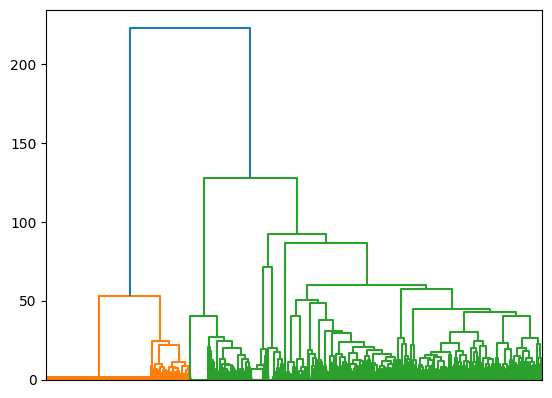

In [22]:
# hierarchical - AgglomerativeClustering
from scipy.cluster import hierarchy as shc

Dendrogram = shc.dendrogram((shc.linkage(X_glove_pca, method ='ward')), no_labels=True)

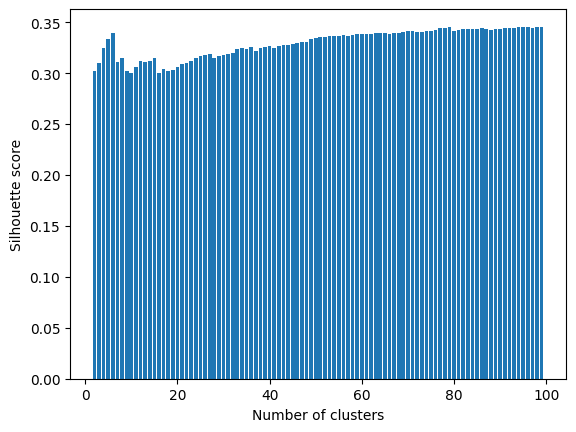

In [12]:
import matplotlib.pyplot as plt

ks = range(2,100)
silhouette_scores_glove = []
for k in ks:
    model = cluster_util.cluster_agglomerative(X_glove_pca, n_clusters=k)
    silhouette_scores_glove.append(cluster_util.eval_cluster_silhouette(X_glove_pca, model.labels_))

# plot
plt.bar(ks, silhouette_scores_glove)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette score')
plt.show()

In [13]:
# outputs the structure of the tree
model = cluster_util.cluster_agglomerative(X_glove_pca, n_clusters=3) #model.labels_
root = cluster_util.aggcluster_to_tree(model)

In [14]:
from bigtree import levelorder_iter

res_nodes = []

for node in levelorder_iter(root):
    if len(list(node.leaves)) in range(20,60):
        res_nodes.append(node)

In [26]:
import random
#take the last one for example
res_names = [leave_node.node_name-1 for leave_node in res_nodes[random.randint(0,len(res_nodes))].leaves]
# see what are they
for i in df_mlerr_g_mlbugs_unique.iloc[res_names].evalue:
    print("==>",i)

==> 'population'
==> 'gdp'
==> 'GDP per Capita'
==> 'income'
==> 'percentage'
==> 'balance'
==> 'quality'
==> 'Salary'
==> 'Adjustments'
==> 'offset'
==> 'Lagged Momentum 12'
==> 'Gain'
==> 'Demand'
==> raise
==> AssertionError not raised by p_norm
==> 0.0 cannot be raised to a negative power
==> Expecting value
==> Expected object or value
==> Expected a callable value, got [[0. 0. 0. 0. 0.]
==> <YearEnd: month=12> is a non-fixed frequency
==> feature_names mismatch: ['Annual Income', 'Credit Score', 'Loan Amount', 'Loan Purpose_Home improvement', 'Loan Purpose_Credit card refinancing', 'Loan Purpose_Debt consolidation', 'Loan Purpose_Medical expenses', 'Loan Purpose_Other', 'Loan Purpose_Car financing', 'Loan Purpose_Major purchase', 'Loan Purpose_Business', 'Loan Purpose_Home buying', 'Loan Purpose_Moving and relocation', 'Loan Purpos
==> bad allocation
==> "['Total Debt / Federal Debt'] not in index"
==> 'Total Purchase value'
==> 'Current Assets'
==> 'Total Current Assets'
==> 'Co

In [27]:
df_mlerr_g_mlbugs_unique.iloc[res_names]

,fname,eid,ename,evalue,traceback,ename_mapped,imports,lib_alias,exp_mllib,exp_mllib_extracted,python_version,evalue_tokenized,hash_evalue_tokenized,cluster_km_glove,cluster_dbscan_glove,cluster_optics_glove
128,00004-157-week1-goals.ipynb,d9f19200-725a-3705-9fc0-642b723620b4,keyerror,'population',['--------------------------------------------...,keyerror,"{('', 'pylab', 'plt'), ('', 'pandas', 'pd'), (...","[['pylab', 'plt'], ['pandas', 'pd'], ['matplot...","[{'library': 'pandas', 'package': 'pandas', 'a...",{'pandas'},3,population,958cdaeaacaf996886cafb5732ea45e0,40,-1,-1
1582,00047-43-9-datacamp-manipulating-dataframes-wi...,2bd76b49-0b63-3257-b045-5997b307b431,keyerror,'gdp',['--------------------------------------------...,keyerror,"{('', 'matplotlib.pyplot', 'plt'), ('', 'panda...","[['matplotlib', 'plt'], ['pandas', 'pd'], ['nu...","[{'library': 'pandas', 'package': 'pandas', 'a...",{'pandas'},3,gdp,0b28b1fc2e8bd910531560f80d677de3,27,-1,1360
9294,00246-188-experiment1.ipynb,d05b4346-6cf5-35e1-abd3-0fadc7798ab2,keyerror,'GDP per Capita',['--------------------------------------------...,keyerror,"{('', 'matplotlib.pyplot', 'plt'), ('', 'sklea...","[['matplotlib', 'plt'], ['sklearn', 'sklearn']...","[{'library': 'pandas', 'package': 'pandas', 'a...","{'numpy', 'pandas'}",3,gdp per capita,b0c0fbf209c5c012a176d37375c00d3a,27,-1,1360
4177,00120-2759-bregession-w2.ipynb,2e56c8bf-e10a-3592-af7a-34fbcb7d981e,keyerror,'income',['--------------------------------------------...,keyerror,"{('', 'statistics', 'st'), ('', 'matplotlib.py...","[['statistics', 'st'], ['matplotlib', 'plt'], ...","[{'library': 'pandas', 'package': 'pandas', 'a...",{'pandas'},-1,income,022c57531cd379d2a65759e9b9fd2bca,27,-1,-1
4510,00129-1355-train-multiimage-frompretrained.ipynb,7d5b957c-fad8-3ede-a23a-a2e6b91144fa,keyerror,'percentage',['--------------------------------------------...,keyerror,"{('torch.utils.data', 'DataLoader', ''), ('vid...","[['torch', 'DataLoader'], ['video_classificati...","[{'library': 'torch', 'package': 'torch', 'com...",{'torch'},-1,percentage,d6997a4c63e1703f129dc5813a597f23,27,-1,-1
9273,00245-546-project-module.ipynb,27710cb0-7994-3a13-8399-b0b3381c7da6,keyerror,'balance',['--------------------------------------------...,keyerror,"{('scripts', 'project_functions', 'pf'), ('', ...","[['scripts', 'pf'], ['seaborn', 'sns'], ['pand...","[{'library': 'pandas', 'package': 'pandas', 'a...",{'pandas'},3,balance,a063576f2ab11ad372aa582fcf9facf4,40,-1,-1
12147,00299-1154-wei-shi-yong-taketobao-cun-yong-01-...,03d35510-62ed-327d-94f2-489e0aa0f7b0,keyerror,'quality',['--------------------------------------------...,keyerror,"{('', 'seaborn', 'sns'), ('sklearn.preprocessi...","[['seaborn', 'sns'], ['sklearn', 'StandardScal...","[{'library': 'sklearn', 'package': 'sklearn', ...","{'matplotlib', 'sklearn', 'pandas'}",3,quality,502bf54ddff666cdbe078c72ee232039,40,-1,-1
6524,00180-522-work.ipynb,15901d11-23a8-3bde-99d3-761cc1cd346a,keyerror,'Salary',['--------------------------------------------...,keyerror,"{('', 'pandas', 'pf')}","[['pandas', 'pf']]","[{'library': 'pandas', 'package': 'pandas', 'a...",{'pandas'},3,salary,986da6d21ebc8dbfff0f088fe1290384,40,-1,-1
12781,00307-2949-8-recurrent-neural-networks.ipynb,c8ed5bdd-856f-3431-a101-0df39f78fe38,keyerror,'Adjustments',['--------------------------------------------...,keyerror,"{('sklearn.preprocessing', 'MinMaxScaler', '')...","[['sklearn', 'MinMaxScaler'], ['matplotlib', '...","[{'library': 'pandas', 'package': 'pandas.tser...",{'pandas'},-1,adjustments,f0110f0cff17035925eca0f71eb889bd,56,-1,-1
12420,00303-2350-describe-port.ipynb,2021540b-fbc7-3865-81ee-bb2fb017aaea,keyerror,'offset',['--------------------------------------------...,keyerror,"{('', 'seaborn', 'sns'), ('', 'pyarrow.parquet...","[['seaborn', 'sns'], ['pyarrow', 'pq'], ['matp...","[{'library': 'pandas', 'package': 'pandas', 'a...",{'pandas'},3,offset,8f2f7700e88104452fa84d562625fe80,27,-1,-1


In [28]:
df_mlerr_g_mlbugs_unique.iloc[res_names].evalue_tokenized

128                                             population
1582                                                   gdp
9294                                        gdp per capita
4177                                                income
4510                                            percentage
9273                                               balance
12147                                              quality
6524                                                salary
12781                                          adjustments
12420                                               offset
6241                                       lagged momentum
10631                                                 gain
1288                                                demand
6774                                                 raise
9914                           assertionerror raised pnorm
11079                                raised negative power
5827                                       expecting val

In [29]:
nk = 80
# print(silhouette_scores_tfidf[nk-2])
# print(silhouette_scores_transformers[nk-2])
print(silhouette_scores_glove[nk-2])

0.3414215879368642


In [ ]:
# LDA, Latent Dirichlet Allocation
# LDA works off the premise that documents with the same topic will have a lot of words in common.
# LDA is a bag of words model meaning that it only considers individual tokens and not their relationships in a sentence.


### 3. Evaluate vectorization and clustering methods

In [39]:
df_mlerr_g_mlbugs_valueerr_unique.columns

Index(['fname', 'eid', 'ename', 'evalue', 'traceback', 'ename_mapped',
       'imports', 'lib_alias', 'exp_mllib', 'exp_mllib_extracted',
       'python_version', 'evalue_tokenized', 'hash_evalue_tokenized',
       'evalue_tokenized_transformer', 'cluster_km_tfidf',
       'cluster_dbscan_tfidf', 'cluster_optics_tfidf',
       'cluster_km_transformers', 'cluster_dbscan_transformers',
       'cluster_optics_transformers', 'cluster_km_glove',
       'cluster_dbscan_glove', 'cluster_optics_glove'],
      dtype='object')

In [41]:
arr_eval = np.zeros((3,3))
name_cols = ['tfidf','word2vec','transformer'] #,'transformer1'
name_rows = ['kmeans','dbscan','optics']

#ss_km_tfidf
arr_eval[0,0] = cluster_util.eval_cluster_silhouette(X_tfidf_pca, df_mlerr_g_mlbugs_valueerr_unique['cluster_km_tfidf'])
#ss_km_glove
arr_eval[0,1] = cluster_util.eval_cluster_silhouette(X_glove_pca, df_mlerr_g_mlbugs_valueerr_unique['cluster_km_glove'])
#ss_km_transformers
arr_eval[0,2] = cluster_util.eval_cluster_silhouette(X_transformers_pca, df_mlerr_g_mlbugs_valueerr_unique['cluster_km_transformers'])
#ss_km_transformers1
# arr_eval[0,3] = cluster_util.eval_cluster_silhouette(X_transformers1, df2_err_ename['cluster_km_transformers1'])

#ss_dbscan_tfidf
arr_eval[1,0] = cluster_util.eval_cluster_silhouette(X_tfidf_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_tfidf']!=-1], 
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_tfidf']!=-1, 'cluster_dbscan_tfidf'])
#ss_dbscan_glove
arr_eval[1,1] = cluster_util.eval_cluster_silhouette(X_glove_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_glove']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_glove']!=-1, 'cluster_dbscan_glove'])
#ss_dbscan_transformers
arr_eval[1,2] = cluster_util.eval_cluster_silhouette(X_transformers_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_transformers']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_dbscan_transformers']!=-1, 'cluster_dbscan_transformers'])
#ss_dbscan_transformers1
# arr_eval[1,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_dbscan_transformers1']!=-1],
#                                         df2_err_ename.loc[df2_err_ename['cluster_dbscan_transformers1']!=-1, 'cluster_dbscan_transformers1'])
#ss_optics_tfidf
arr_eval[2,0] = cluster_util.eval_cluster_silhouette(X_tfidf_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_tfidf']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_tfidf']!=-1, 'cluster_optics_tfidf'])
#ss_optics_glove
arr_eval[2,1] = cluster_util.eval_cluster_silhouette(X_glove_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_glove']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_glove']!=-1, 'cluster_optics_glove'])
#ss_optics_transformers
arr_eval[2,2] = cluster_util.eval_cluster_silhouette(X_transformers_pca[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_transformers']!=-1],
                                        df_mlerr_g_mlbugs_valueerr_unique.loc[df_mlerr_g_mlbugs_valueerr_unique['cluster_optics_transformers']!=-1, 'cluster_optics_transformers'])
#ss_optics_transformers1
# arr_eval[2,3] = cluster_util.eval_cluster_silhouette(X_transformers1[df2_err_ename['cluster_optics_transformers1']!=-1],
#                                         df2_err_ename.loc[df2_err_ename['cluster_optics_transformers1']!=-1, 'cluster_optics_transformers1'])

In [42]:
df_eval = pd.DataFrame(arr_eval, index=name_rows, columns=name_cols)
df_eval

,tfidf,word2vec,transformer
kmeans,0.157953,0.107939,0.109920
dbscan,0.350171,0.286836,0.029276
optics,0.463592,0.442552,0.345431


selected optimal clustering method + wordembeddings = optics + word2vec(GloVe)